In [28]:
import pandas as pd
import numpy as np 
import pickle
import os

from itertools import cycle
from collections import defaultdict
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


In [29]:
rootdir = os.getcwd() + "/data/training/"

data             = []
data_label       = []


for subdir, dirs, files in os.walk(rootdir):
    for fl in files:
        if fl.endswith('.pkl'):
            # string split for event labelling
            str_arr = fl.split('_')
            label   = str_arr[1]

            # read data and append it to variable
            infile = open((rootdir + fl),'rb')
            new_dict = pickle.load(infile, encoding='latin1')

            data.append(new_dict)
            data_label.append(new_dict['label'])

In [30]:
keys = [
    'Magnetometer', 
    'Accelerometer', 
    'LinearAccelerometer', 
    'JinsGyroscope', 
    'Gravity', 
    'MSAccelerometer',
    'JinsAccelerometer',
    'MSGyroscope',
    'Gyroscope',
    'JinsEyeMovement',
    # 'JinsBlinkStrength', Excluded because some data has no JinsBlinkStrength data
    'rightHand',
    'label'
]

ary = []
for dt in data:
    internal = []
    for key in keys[:-2]:
        feature = dt[key]
        for column in feature.T:
            internal.append(np.mean(column))
            internal.append(np.var(column))
            internal.append(np.max(column))
            internal.append(np.min(column))
            
    # Right hand - If true 1 else 0
    right_hand = 1 if dt["rightHand"] else 0
    internal.append(right_hand)

    internal.append(dt["label"])

    ary.append(internal)

In [31]:
df = pd.DataFrame(ary)

# Name df columns, so it's more clear
df_columns = []

# Iterate through except label, rightHand, JinsEyeMovement, JinsBlinkStrength
for key in keys[:-3]:
    df_columns.append('{} X (mean)'.format(key))
    df_columns.append('{} X (var)'.format(key))
    df_columns.append('{} X (max)'.format(key))
    df_columns.append('{} X (min)'.format(key))

    df_columns.append('{} Y (mean)'.format(key))
    df_columns.append('{} Y (var)'.format(key))
    df_columns.append('{} Y (max)'.format(key))
    df_columns.append('{} Y (min)'.format(key))

    df_columns.append('{} Z (mean)'.format(key))
    df_columns.append('{} Z (var)'.format(key))
    df_columns.append('{} Z (max)'.format(key))
    df_columns.append('{} Z (min)'.format(key))

# JinsEyeMovement (4 dimensions)
for i in range(4):
    df_columns.append('JinsEyeMovement Dim-{} (mean)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (var)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (max)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (min)'.format(i+1))

df_columns.append('rightHand')

df_columns.append('label')

df.columns = df_columns

df

,Magnetometer X (mean),Magnetometer X (var),Magnetometer X (max),Magnetometer X (min),Magnetometer Y (mean),Magnetometer Y (var),Magnetometer Y (max),Magnetometer Y (min),Magnetometer Z (mean),Magnetometer Z (var),...,JinsEyeMovement Dim-3 (mean),JinsEyeMovement Dim-3 (var),JinsEyeMovement Dim-3 (max),JinsEyeMovement Dim-3 (min),JinsEyeMovement Dim-4 (mean),JinsEyeMovement Dim-4 (var),JinsEyeMovement Dim-4 (max),JinsEyeMovement Dim-4 (min),rightHand,label
0,4.991582,3.368823,9.3125,1.9375,-32.884439,0.634716,-31.1875,-35.2500,26.872449,0.663769,...,0.0,0.0,0.0,0.0,0.009901,0.009803,1.0,0.0,0,0
1,4.999238,7.892133,7.7500,-2.5625,-40.103659,1.256309,-37.8750,-43.4375,-1.536331,3.767433,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
2,8.244621,33.212013,14.1250,-1.7500,-37.640113,1.081339,-35.2500,-40.8125,9.581711,26.765016,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
3,8.289634,0.321695,9.6875,6.6875,-39.676829,0.765797,-37.8750,-41.9375,3.122967,1.000790,...,0.0,0.0,0.0,0.0,0.010000,0.009900,1.0,0.0,0,0
4,18.582317,0.217309,20.0000,17.3750,-39.456047,0.764281,-37.5000,-41.5625,-7.030488,0.467312,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,7.735204,161.662281,22.8125,-15.6250,-40.539796,17.689041,-26.6875,-46.6875,5.139286,130.851199,...,0.0,0.0,0.0,0.0,0.010309,0.010203,1.0,0.0,0,5
70,-9.915142,36.056030,3.6250,-20.0625,-38.599593,22.883152,-24.1250,-44.8125,13.914888,202.051969,...,0.0,0.0,0.0,0.0,0.010101,0.009999,1.0,0.0,0,5
71,16.424595,7.723027,21.6875,11.3750,-39.404858,8.020617,-30.8125,-43.3750,7.795547,75.613120,...,0.0,0.0,0.0,0.0,0.010000,0.009900,1.0,0.0,0,5
72,16.982540,8.874426,23.5625,11.3750,-39.111336,8.218943,-30.8125,-43.3750,6.743927,108.311894,...,0.0,0.0,0.0,0.0,0.010101,0.009999,1.0,0.0,0,5


# RandomForestClassifier without pre-processing

In [32]:
X = df.iloc[:, 0:(len(df.columns)-1)].to_numpy() # All features except label
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

# Cross fold validation - 10 folds
scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print('cross fold validation scores:', scores)
print('cross fold validation score average', scores.mean())
print('cross fold validation score standard deviation', scores.std())

cross fold validation scores: [0.75       0.875      0.875      1.         0.85714286 1.
 1.         1.         1.         0.85714286]
cross fold validation score average 0.9214285714285715
cross fold validation score standard deviation 0.08534145103820373


# Feature selections by using RandomForestClassifier

In [33]:
X = df.iloc[:, 0:(len(df.columns)-1)]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(X_train, y_train)

sel.get_support()

# Array of columns that regarded as best features by random forest classifier above
selected_feats= X_train.columns[(sel.get_support())]

selected_feats

Index(['Magnetometer Y (mean)', 'Magnetometer Y (max)', 'Magnetometer Y (min)',
       'Magnetometer Z (mean)', 'Magnetometer Z (var)', 'Magnetometer Z (min)',
       'Accelerometer X (var)', 'Accelerometer X (min)',
       'Accelerometer Y (mean)', 'Accelerometer Y (max)',
       'Accelerometer Y (min)', 'Accelerometer Z (mean)',
       'Accelerometer Z (var)', 'Accelerometer Z (max)',
       'LinearAccelerometer X (mean)', 'LinearAccelerometer X (var)',
       'LinearAccelerometer Y (mean)', 'LinearAccelerometer Y (var)',
       'LinearAccelerometer Y (max)', 'LinearAccelerometer Y (min)',
       'LinearAccelerometer Z (var)', 'LinearAccelerometer Z (max)',
       'JinsGyroscope Y (mean)', 'JinsGyroscope Y (max)',
       'JinsGyroscope Y (min)', 'Gravity X (mean)', 'Gravity X (min)',
       'Gravity Y (mean)', 'Gravity Y (var)', 'Gravity Y (max)',
       'Gravity Y (min)', 'Gravity Z (mean)', 'Gravity Z (var)',
       'Gravity Z (max)', 'Gravity Z (min)', 'MSAccelerometer X (mean)',


# RandomForestClassifier with selected features

In [34]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# Cross fold validation - 10 folds
scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print('cross fold validation scores:', scores)
print('cross fold validation score average', scores.mean())
print('cross fold validation score standard deviation', scores.std())

cross fold validation scores: [0.75       1.         0.875      1.         0.85714286 1.
 1.         1.         1.         0.85714286]
cross fold validation score average 0.9339285714285716
cross fold validation score standard deviation 0.08676807580897389


# Logistic Regression with StandardScaler and selected features

In [35]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000).fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print('cross fold validation scores:', scores)
print('cross fold validation score average', scores.mean())
print('cross fold validation score standard deviation', scores.std())

cross fold validation scores: [0.875 1.    0.75  1.    1.    1.    1.    1.    1.    1.   ]
cross fold validation score average 0.9625
cross fold validation score standard deviation 0.08003905296791061


# SVM with StandardScaler and selected features

In [36]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

clf = SVC(gamma='auto', random_state=0).fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print('cross fold validation scores:', scores)
print('cross fold validation score average', scores.mean())
print('cross fold validation score standard deviation', scores.std())

cross fold validation scores: [0.875      1.         0.75       1.         0.85714286 1.
 1.         1.         1.         1.        ]
cross fold validation score average 0.9482142857142858
cross fold validation score standard deviation 0.0846850407241384


# KNN with StandardScaler and selected features

In [37]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print('cross fold validation scores:', scores)
print('cross fold validation score average', scores.mean())
print('cross fold validation score standard deviation', scores.std())

cross fold validation scores: [0.875      0.875      0.75       0.875      0.85714286 0.85714286
 1.         0.85714286 0.85714286 1.        ]
cross fold validation score average 0.8803571428571427
cross fold validation score standard deviation 0.06918346652789471


# AUC-ROC Curve (OneVsRest SVM)

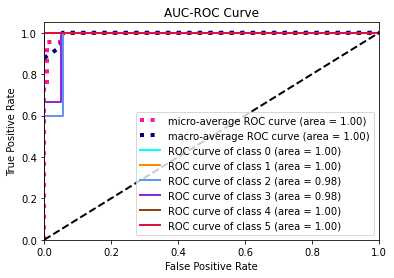

In [40]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(SVC(random_state=42)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

# AUC-ROC Curve (OneVsRest Logistic Regression)

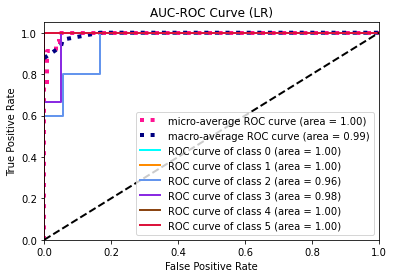

In [42]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (LR)')
plt.legend(loc="lower right")
plt.show()

# AUC-ROC Curve (OneVsRest RandomForest)

In [43]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(RandomForestClassifier(random_state=0)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (LR)')
plt.legend(loc="lower right")
plt.show()